In [28]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from settings import colors, titles, letter_size

In [2]:
exp = "10"
base_path = f"/storage/fits/neurocorr/exp{exp}"

In [3]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')
roi_path = os.path.join("/storage/data/ret2/roi_positions.mat")
# Extra datasets
# pvc11_2_path = os.path.join(base_path, 'exp09_2_pvc11_15_1000_1000.h5')
# pvc11_3_path = os.path.join(base_path, 'exp09_3_pvc11_15_1000_1000.h5')

In [4]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

# Extra datasets
# pvc11_2 = h5py.File(pvc11_2_path, 'r')
# pvc11_3 = h5py.File(pvc11_3_path, 'r')

In [5]:
rois = h5py.File(roi_path, 'r')
positions = rois['xyPosDS'][:]
distances = np.linalg.norm(positions[:, :, np.newaxis] - positions[:, np.newaxis, :], axis=0)

In [6]:
n_max_units = ret2['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)

In [7]:
groups = [
    'v_lfi',
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
labels = [
    'Observed',
    'Shuffle',
    'Uniform',
    'FA'
]
percentile_groups = [
    'p_u_lfi',
    'p_fa_lfi'
]
value_groups = [
    'v_s_lfi',
    'v_u_lfi',
    'v_fa_lfi'
]
lfi_models = [
    'observed',
    'shuffle',
    'uniform',
    'fa'
]
models = [
    'uniform',
    'fa'
]
labels2 = [
    'Uniform',
    'FA'
]

In [8]:
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_null_equiv_cdfs, all_opt_fa_equiv_cdfs, all_opt_equiv_cdfs = pickle.load(f)

with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_r_ffs, opt_fa_ffs, obs_ffs = pickle.load(f)

In [9]:
fa_cdf_mse = []
fa_cdf_rank = []
fa_ff_mse = []
fa_ff_rank = []
avg_rank = []
best_obs_p_rank = np.zeros((3, 18, 3))
p_lower = 90
p_upper = 100
obs_percentile_lower = 25
obs_percentile_upper = 75

for result_idx, result in enumerate(results):
    fa_ff_mse.append((opt_fa_ffs[result_idx] - obs_ffs[result_idx])**2)
    fa_ff_rank.append(np.argsort(fa_ff_mse[-1], axis=-1))
    ff_mse_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        fa_max = np.max(all_opt_fa_equiv_cdfs[result_idx][dim], axis=-1)
        equiv_max = np.max(all_null_equiv_cdfs[result_idx][dim], axis=-1)
        ff_mse_temp[dim_idx] = (fa_max - equiv_max)**2
    fa_cdf_mse.append(ff_mse_temp)
    fa_cdf_rank.append(np.argsort(fa_cdf_mse[-1], axis=-1))
    avg_rank.append(-0.5 * (fa_ff_rank[-1] + fa_cdf_rank[-1]))
    
    # Grab observed percentiles for best avg ranks
    best_obs_p_temp = np.zeros_like(fa_ff_mse[-1])
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_rank[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[p_lower, p_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        best_obs_p_rank[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

In [10]:
# RET2
ret2_data_path = '/storage/data/ret2/200114_fov1_data.mat'
ret2_pack = packs.RET2(data_path=ret2_data_path)
X_ret2 = ret2_pack.get_response_matrix(cells='tuned', response='max')
# PVC11 - 1
pvc11_1_data_path = '/storage/data/pvc11/data/spikes_gratings/data_monkey1_gratings.mat'
pvc11_1_pack = packs.PVC11(data_path=pvc11_1_data_path)
X_pvc11 = pvc11_1_pack.get_response_matrix(transform=None)
# ECOG
ecog_data_path = '/storage/data/ecog/r32_b7.mat'
ecog_pack = packs.ECOG(data_path=ecog_data_path)
X_ecog = ecog_pack.get_response_matrix(bounds=[40, 60], band='HG', electrodes=ecog_pack.pac_idxs)

In [11]:
mu_ret2 = np.zeros((ret2_pack.n_angles, X_ret2.shape[1]))
mu_pvc11 = np.zeros((pvc11_1_pack.n_stimuli, X_pvc11.shape[1]))
mu_ecog = np.zeros((ecog_pack.freq_set.size, X_ecog.shape[1]))

for idx, angle in enumerate(ret2_pack.unique_angles):
    mu_ret2[idx] = X_ret2[ret2_pack.angles == angle].mean(axis=0)

for idx, angle in enumerate(pvc11_1_pack.get_angles()):
    mu_pvc11[idx] = X_pvc11[pvc11_1_pack.get_design_matrix() == angle].mean(axis=0)
    
for idx, frequency in enumerate(ecog_pack.freq_set):
    mu_ecog[idx] = X_ecog[ecog_pack.get_design_matrix('frequency') == frequency].mean(axis=0)

In [12]:
rank_ret2 = -np.argsort(mu_ret2, axis=0)
rank_pvc11 = -np.argsort(mu_pvc11, axis=0)
rank_ecog = -np.argsort(mu_ecog, axis=0)
ranks = [rank_ret2, rank_pvc11, rank_ecog]

In [13]:
avg_tuning_ranks = []

p_lower = 90
p_upper = 100
obs_percentile_lower = 25
obs_percentile_upper = 75
best_tuning_p_rank_fa = np.zeros((3, 18, 3))
best_tuning_p_rank_u = np.zeros((3, 18, 3))

for result_idx, (result, rank) in enumerate(zip(results, ranks)):
    n_dimstims = result['p_r_lfi'].shape[1]
    avg_tuning_ranks_temp = np.zeros((dims.size, n_dimstims))
    unique_stimuli = np.unique(result['stimuli'][:])

    for dim_idx, dim in enumerate(dims):
        for dimstim_idx in range(n_dimstims):
            units = result['units'][dim_idx, dimstim_idx][:dim]
            stims = result['stims'][dim_idx, dimstim_idx]
            rank1 = np.mean(rank[unique_stimuli == stims[0]][:, units])
            rank2 = np.mean(rank[unique_stimuli == stims[1]][:, units])
            total_rank = 0.5 * (rank1 + rank2)
            avg_tuning_ranks_temp[dim_idx, dimstim_idx] = total_rank
    avg_tuning_ranks.append(avg_tuning_ranks_temp)
    
    for dim_idx, dim in enumerate(dims):
        avg_rank_temp = avg_tuning_ranks[-1][dim_idx]
        rank_lower, rank_upper = np.percentile(avg_rank_temp, q=[p_lower, p_upper])
        p_fa_lfi_slice = result['p_fa_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        p_u_lfi_slice = result['p_u_lfi'][dim_idx][(avg_rank_temp > rank_lower) & (avg_rank_temp <= rank_upper)]
        best_tuning_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])
        best_tuning_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

# Positions

In [15]:
n_ret2_dimlets = 1000
n_ret2_dimstims = 6 * n_ret2_dimlets
dimlet_distances = np.zeros((dims.size, n_ret2_dimstims))

units = ret2['units'][:]
for dim_idx, dim in enumerate(dims):
    for dimlet_idx in range(n_ret2_dimstims):
        unit_temp = units[dim_idx, dimlet_idx, :dim]
        tri_idx = np.triu_indices(dim, k=1)
        mean_dist = np.mean(distances[unit_temp][:, unit_temp][tri_idx])
        dimlet_distances[dim_idx, dimlet_idx] = mean_dist

rank_distances = -np.argsort(dimlet_distances, axis=1)

In [16]:
p_lower = 90
p_upper = 100
obs_percentile_lower = 25
obs_percentile_upper = 75
best_position_p_rank_fa = np.zeros((3, 18, 3))
best_position_p_rank_u = np.zeros((3, 18, 3))

for dim_idx, dim in enumerate(dims):
    rank_temp = rank_distances[dim_idx]
    rank_lower, rank_upper = np.percentile(rank_temp, q=[p_lower, p_upper])
    p_fa_lfi_slice = ret2['p_fa_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
    p_u_lfi_slice = ret2['p_u_lfi'][dim_idx][(rank_temp > rank_lower) & (rank_temp <= rank_upper)]
    best_position_p_rank_fa[result_idx, dim_idx] = np.percentile(p_fa_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])
    best_position_p_rank_u[result_idx, dim_idx] = np.percentile(p_u_lfi_slice, q=[obs_percentile_lower, 50, obs_percentile_upper])

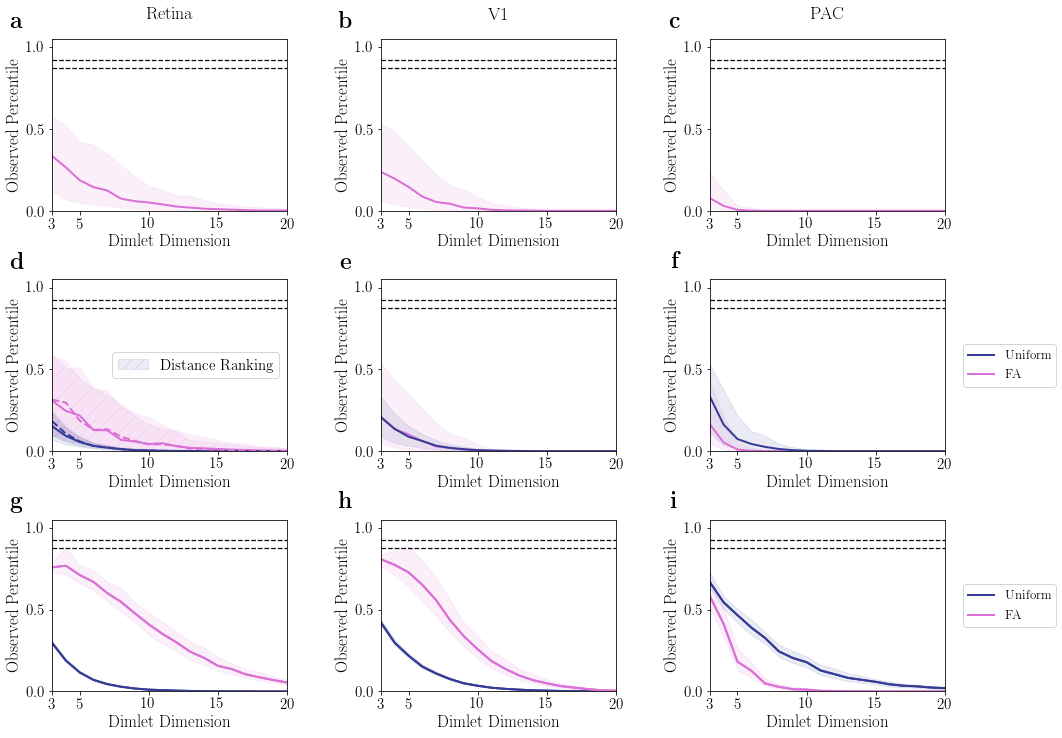

In [41]:
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.4)

# Label adjustments
subplot_label_size = 22
axis_label_size = 16
title_size = 18
subplot_x = -0.18
subplot_y = 1.12
title_pad = 20
# Line settings
linewidth = 2
line_alpha = 0.8
obs_lw = 2
# Fill settings
fill_alpha = 0.1
# Legend settings
legend_size = 13
handlelength = 0.3
handletextpad = 0.3
# Font sizes
label_font_size = 17
tick_font_size = 15
subplot_label_size = 23
# Percentile bounds for curves
percentile_lower = 40
percentile_upper = 60

# Enumerate over results
for idx, result in enumerate(results):
    # Iterate over null models
    for group, model in zip(percentile_groups, models):
        # Calculate median and bounds for each null model
        percentiles = result[group][:]
        lower_q = 87.5
        upper_q = 92.5
        middle_q = 0.5 * (upper_q + lower_q)
        lower, middle, upper = np.percentile(percentiles, q=[lower_q, middle_q, upper_q], axis=1)

        axes[2, idx].plot(
            dims,
            middle,
            linewidth=linewidth,
            color=colors[model])

        axes[2, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha)

        lower, upper = np.percentile(avg_rank[idx], q=[lower_q, upper_q], axis=1)
        
        
        axes[2, idx].plot(
            dims,
            middle,
            linewidth=linewidth,
            color=colors[model])

        axes[2, idx].fill_between(
            x=dims,
            y1=lower,
            y2=upper,
            color=colors[model],
            alpha=fill_alpha)
    axes[2, idx].axhline(lower_q / 100, linestyle='--', color='k', lw=1.25)
    axes[2, idx].axhline(upper_q / 100, linestyle='--', color='k', lw=1.25)
        
    # Average rank over dimensions
    axes[0, idx].plot(
        dims,
        best_obs_p_rank[idx, :, 1],
        linewidth=linewidth,
        color=colors[model])

    axes[0, idx].fill_between(
        x=dims,
        y1=best_obs_p_rank[idx, :, 0],
        y2=best_obs_p_rank[idx, :, 2],
        color=colors[model],
        alpha=fill_alpha)
    axes[0, idx].axhline(lower_q / 100, linestyle='--', color='k', lw=1.25)
    axes[0, idx].axhline(upper_q / 100, linestyle='--', color='k', lw=1.25)

    # Average rank over dimensions
    axes[1, idx].plot(
        dims,
        best_tuning_p_rank_fa[idx, :, 1],
        linewidth=linewidth,
        color=colors['fa'])

    axes[1, idx].fill_between(
        x=dims,
        y1=best_tuning_p_rank_fa[idx, :, 0],
        y2=best_tuning_p_rank_fa[idx, :, 2],
        color=colors['fa'],
        alpha=fill_alpha)
    
    # Average rank over dimensions
    axes[1, idx].plot(
        dims,
        best_tuning_p_rank_u[idx, :, 1],
        linewidth=linewidth,
        color=colors['uniform'])

    axes[1, idx].fill_between(
        x=dims,
        y1=best_tuning_p_rank_u[idx, :, 0],
        y2=best_tuning_p_rank_u[idx, :, 2],
        color=colors['uniform'],
        alpha=fill_alpha)
    
    axes[1, idx].axhline(lower_q / 100, linestyle='--', color='k', lw=1.25)
    axes[1, idx].axhline(upper_q / 100, linestyle='--', color='k', lw=1.25)

    
axes[1, 0].plot(
    dims,
    best_position_p_rank_u[idx, :, 1],
    linewidth=linewidth,
    linestyle='--',
    color=colors['uniform'])

axes[1, 0].fill_between(
    x=dims,
    y1=best_position_p_rank_u[idx, :, 0],
    y2=best_position_p_rank_u[idx, :, 2],
    color=colors['uniform'],
    hatch='//',
    label='Distance Ranking',
    alpha=fill_alpha)

axes[1, 0].legend(loc='best', prop={'size': 15})

axes[1, 0].plot(
    dims,
    best_position_p_rank_fa[idx, :, 1],
    linewidth=linewidth,
    linestyle='--',
    color=colors['fa'])

axes[1, 0].fill_between(
    x=dims,
    y1=best_position_p_rank_fa[idx, :, 0],
    y2=best_position_p_rank_fa[idx, :, 2],
    color=colors['fa'],
    hatch='//',
    alpha=fill_alpha)

for idx, ax in enumerate(axes.ravel()):
    ax.set_xlim([3, 20])
    ax.set_ylim([0, 1.05])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([0, .5, 1])
    ax.tick_params(labelsize=tick_font_size)
    
    ax.set_xlabel('Dimlet Dimension', fontsize=label_font_size)
    ax.set_ylabel('Observed Percentile', fontsize=label_font_size)
    
for idx, ax in enumerate(axes[0]):
    ax.set_title(titles[idx], fontsize=title_size, pad=title_pad)

    
for model, label in zip(models, labels2):
    axes[1, -1].plot([], [], color=colors[model], label=label, linewidth=linewidth)
    axes[2, -1].plot([], [], color=colors[model], label=label, linewidth=linewidth)

axes[1, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})
axes[2, -1].legend(
    loc='center left',
    bbox_to_anchor=(1.05, 0.5),
    prop={'size': legend_size})

mplego.labels.apply_subplot_labels(axes, bold=True, y=1.1, size=23)
plt.savefig('figure7.pdf', bbox_inches='tight')